# Percolation and Cluster Formation in GPT-2
## Network Visualization of Token Connectivity Through Layers

This notebook visualizes how tokens form connectivity networks as they pass through GPT-2 and Wen family transformer layers.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from typing import List, Dict, Tuple
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(39)
torch.manual_seed(39)

In [41]:
# Configuration
MODEL_NAME = 'gpt2'
THRESHOLD = 0.8
USE_COSINE = True

# Create output directory
import os
OUTPUT_DIR = 'D:\GWU\DATS6450(Cloud Network)\gephi'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Sample corpus
CORPUS = [
    "The cat sat on the mat and watched.",
    "Machine learning models process data using neural networks.",
    "Climate change affects ecosystems around the world.",
    "Quantum computers use superposition for parallel computation.",
    "The universe contains billions of galaxies.",
    "Artificial intelligence transforms how we work.",
    "DNA stores genetic information in cells.",
    "Ocean currents regulate Earth's climate system.",
    "Photosynthesis converts sunlight into chemical energy.",
    "Blockchain technology enables decentralized systems.",
    "Many people once believed the Earth was flat, but centuries of observation and exploration proved it is round."
]

In [42]:
def load_model_and_tokenizer(model_name: str):
    """Load GPT-2 model and tokenizer."""
    print(f"Loading {model_name}...")
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name, output_hidden_states=True)
    model.eval()
    return model, tokenizer

In [43]:
def extract_hidden_states(model, tokenizer, text: str):
    """Extract hidden states at each layer for a given text."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=20)

    with torch.no_grad():
        outputs = model(**inputs)

    # hidden_states: tuple of (num_layers+1) tensors
    # Each tensor: [batch_size, seq_length, hidden_dim]
    hidden_states = outputs.hidden_states

    # Convert to numpy: [num_layers, seq_length, hidden_dim]
    hidden_arrays = [h[0].cpu().numpy() for h in hidden_states]

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    return hidden_arrays, tokens

In [44]:
def compute_similarity_matrix(hidden_state, use_cosine=True):
    """Compute pairwise similarity matrix between tokens."""
    n = hidden_state.shape[0]

    if use_cosine:
        # Normalize for cosine similarity
        norms = np.linalg.norm(hidden_state, axis=1, keepdims=True)
        normalized = hidden_state / (norms + 1e-8)
        similarity = normalized @ normalized.T
    else:
        # Dot product
        similarity = hidden_state @ hidden_state.T

    return similarity

In [45]:
def build_connectivity_graph(similarity_matrix, threshold, tokens):
    """Build networkx graph from similarity matrix."""
    n = len(similarity_matrix)
    G = nx.Graph()

    # Add nodes with token labels
    for i in range(n):
        G.add_node(i, token=tokens[i])

    # Add edges where similarity exceeds threshold
    for i in range(n):
        for j in range(i+1, n):
            if similarity_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    return G

In [46]:
def analyze_graph_structure(G):
    """Compute percolation observables from graph."""
    if len(G.nodes()) == 0:
        return {
            'phi': 0.0,
            'num_clusters': 0,
            'chi': 0.0,
            'largest_component_size': 0,
            'component_sizes': []
        }

    # Find connected components
    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]

    if len(component_sizes) == 0:
        largest = 0
    else:
        largest = max(component_sizes)

    n = len(G.nodes())
    phi = largest / n if n > 0 else 0.0

    # Mean cluster size (excluding GCC)
    if len(component_sizes) > 1:
        non_gcc_sizes = [s for s in component_sizes if s != largest]
        chi = np.mean(non_gcc_sizes) if len(non_gcc_sizes) > 0 else 0.0
    else:
        chi = 0.0

    return {
        'phi': phi,
        'num_clusters': len(components),
        'chi': chi,
        'largest_component_size': largest,
        'component_sizes': sorted(component_sizes, reverse=True)
    }

In [47]:
def visualize_network(G, tokens, layer_num, title="", ax=None, layout='spring'):
    """Visualize the connectivity network."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    if len(G.nodes()) == 0:
        ax.text(0.5, 0.5, 'No nodes', ha='center', va='center')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.axis('off')
        return

    # Find connected components
    components = list(nx.connected_components(G))
    largest_component = max(components, key=len) if components else set()

    # Color nodes by component
    node_colors = []
    for node in G.nodes():
        if node in largest_component:
            node_colors.append('#e74c3c')  # Red for GCC
        else:
            node_colors.append('#3498db')  # Blue for small clusters

    # Layout
    if layout == 'spring':
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    else:
        pos = nx.kamada_kawai_layout(G)

    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=500, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.5, ax=ax)

    # Draw labels
    labels = {i: tokens[i][:8] for i in G.nodes()}  # Truncate long tokens
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)

    # Analyze structure
    stats = analyze_graph_structure(G)

    # Title with statistics
    title_text = f"{title}\n"
    title_text += f"Layer {layer_num} | "
    title_text += f"GCC: {stats['largest_component_size']}/{len(G.nodes())} "
    title_text += f"({stats['phi']:.1%}) | "
    title_text += f"Clusters: {stats['num_clusters']}"

    ax.set_title(title_text, fontsize=10, pad=10)
    ax.axis('off')

    return stats

## Load Model and Analyze Single Example

In [48]:
# Load model
model, tokenizer = load_model_and_tokenizer(MODEL_NAME)
num_layers = len(model.transformer.h) + 1
print(f"Number of layers: {num_layers}")

Loading gpt2...
Number of layers: 13


## Visualize Network Formation for a Single Sequence

In [49]:
# Analyze first sequence in detail
example_text = CORPUS[10]
print(f"Analyzing: '{example_text}'\n")

hidden_states, tokens = extract_hidden_states(model, tokenizer, example_text)
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")
print(f"Number of layers: {len(hidden_states)}")

Analyzing: 'Many people once believed the Earth was flat, but centuries of observation and exploration proved it is round.'

Tokens: ['Many', 'Ġpeople', 'Ġonce', 'Ġbelieved', 'Ġthe', 'ĠEarth', 'Ġwas', 'Ġflat', ',', 'Ġbut', 'Ġcenturies', 'Ġof', 'Ġobservation', 'Ġand', 'Ġexploration', 'Ġproved', 'Ġit', 'Ġis', 'Ġround', '.']
Number of tokens: 20
Number of layers: 13


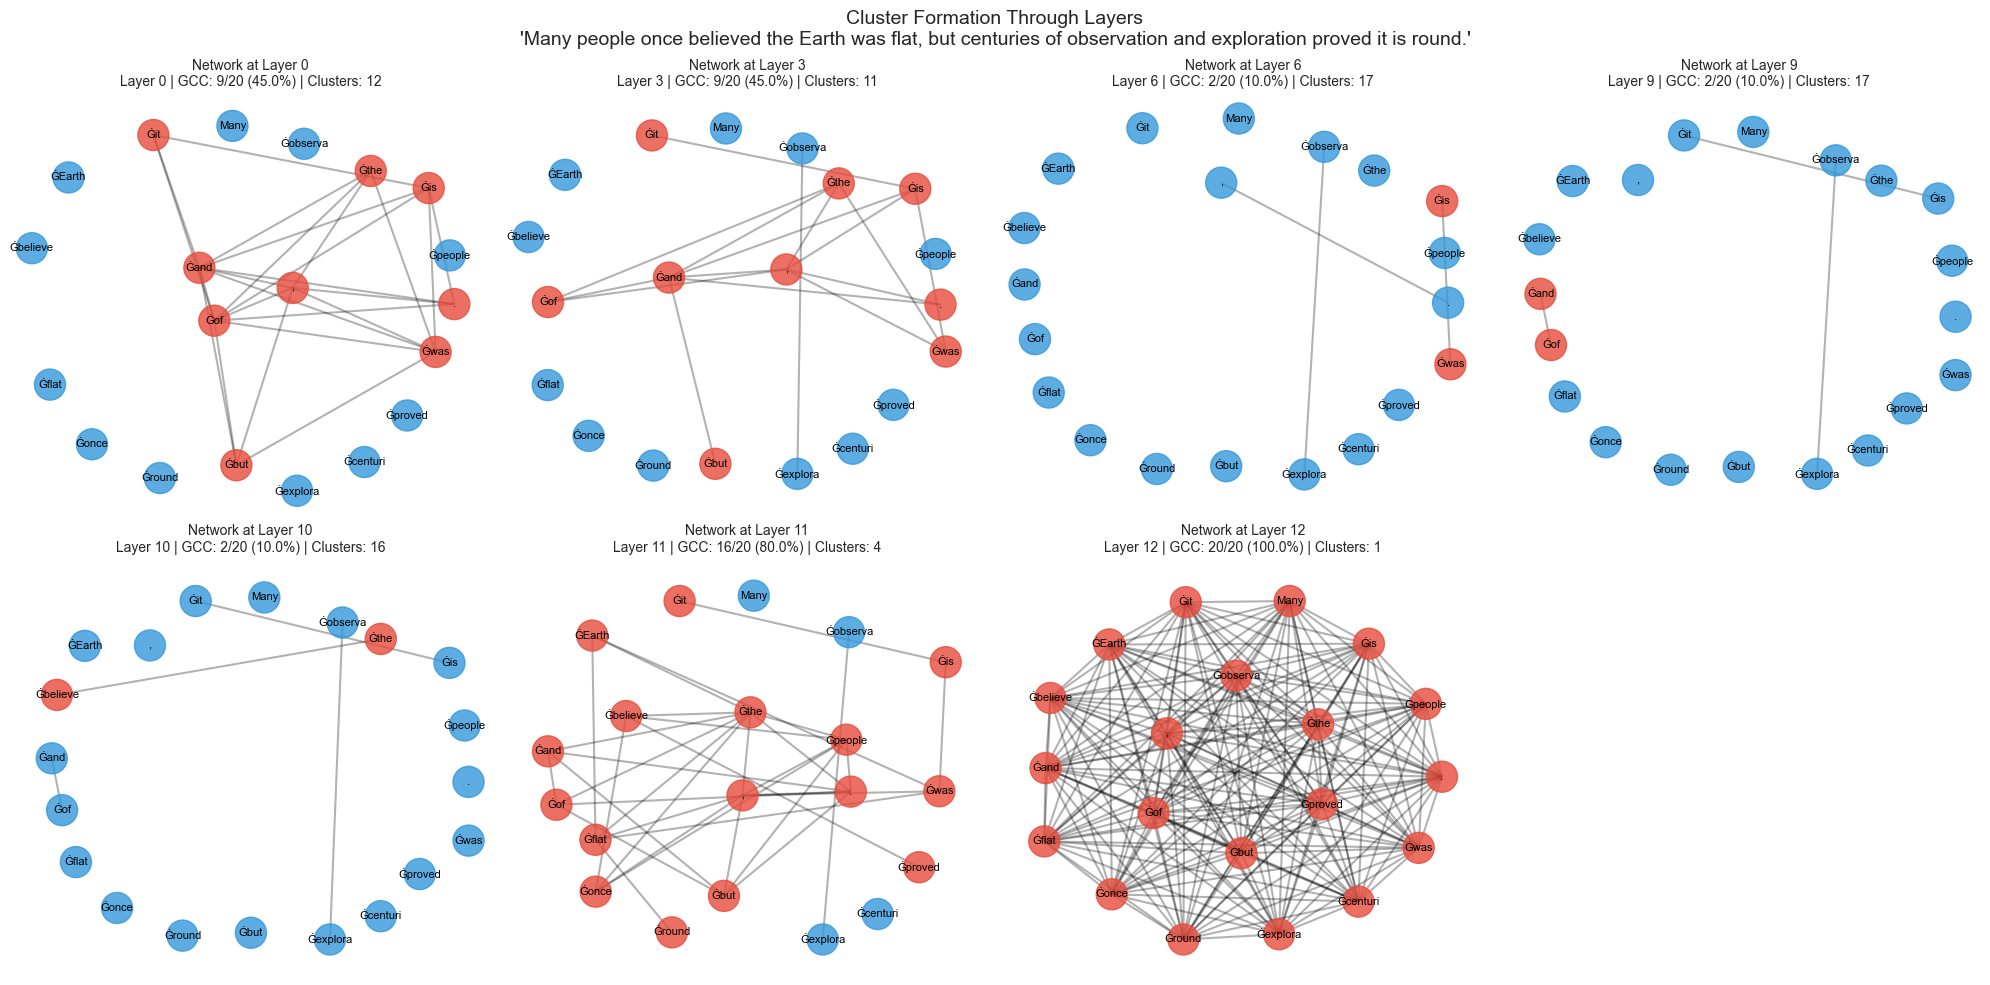

In [50]:
# Create networks for key layers showing the evolution
key_layers = [0, 3, 6, 9, 10, 11, 12]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, layer in enumerate(key_layers):
    if idx < len(axes):
        # Compute similarity matrix
        similarity = compute_similarity_matrix(hidden_states[layer], use_cosine=USE_COSINE)

        # Build graph
        G = build_connectivity_graph(similarity, THRESHOLD, tokens)

        # Visualize
        visualize_network(G, tokens, layer,
                         title=f"Network at Layer {layer}",
                         ax=axes[idx], layout='spring')

# Hide unused subplot
axes[-1].axis('off')

plt.suptitle(f"Cluster Formation Through Layers\n'{example_text}'",
            fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

## Animation-Style: Layer by Layer Progression

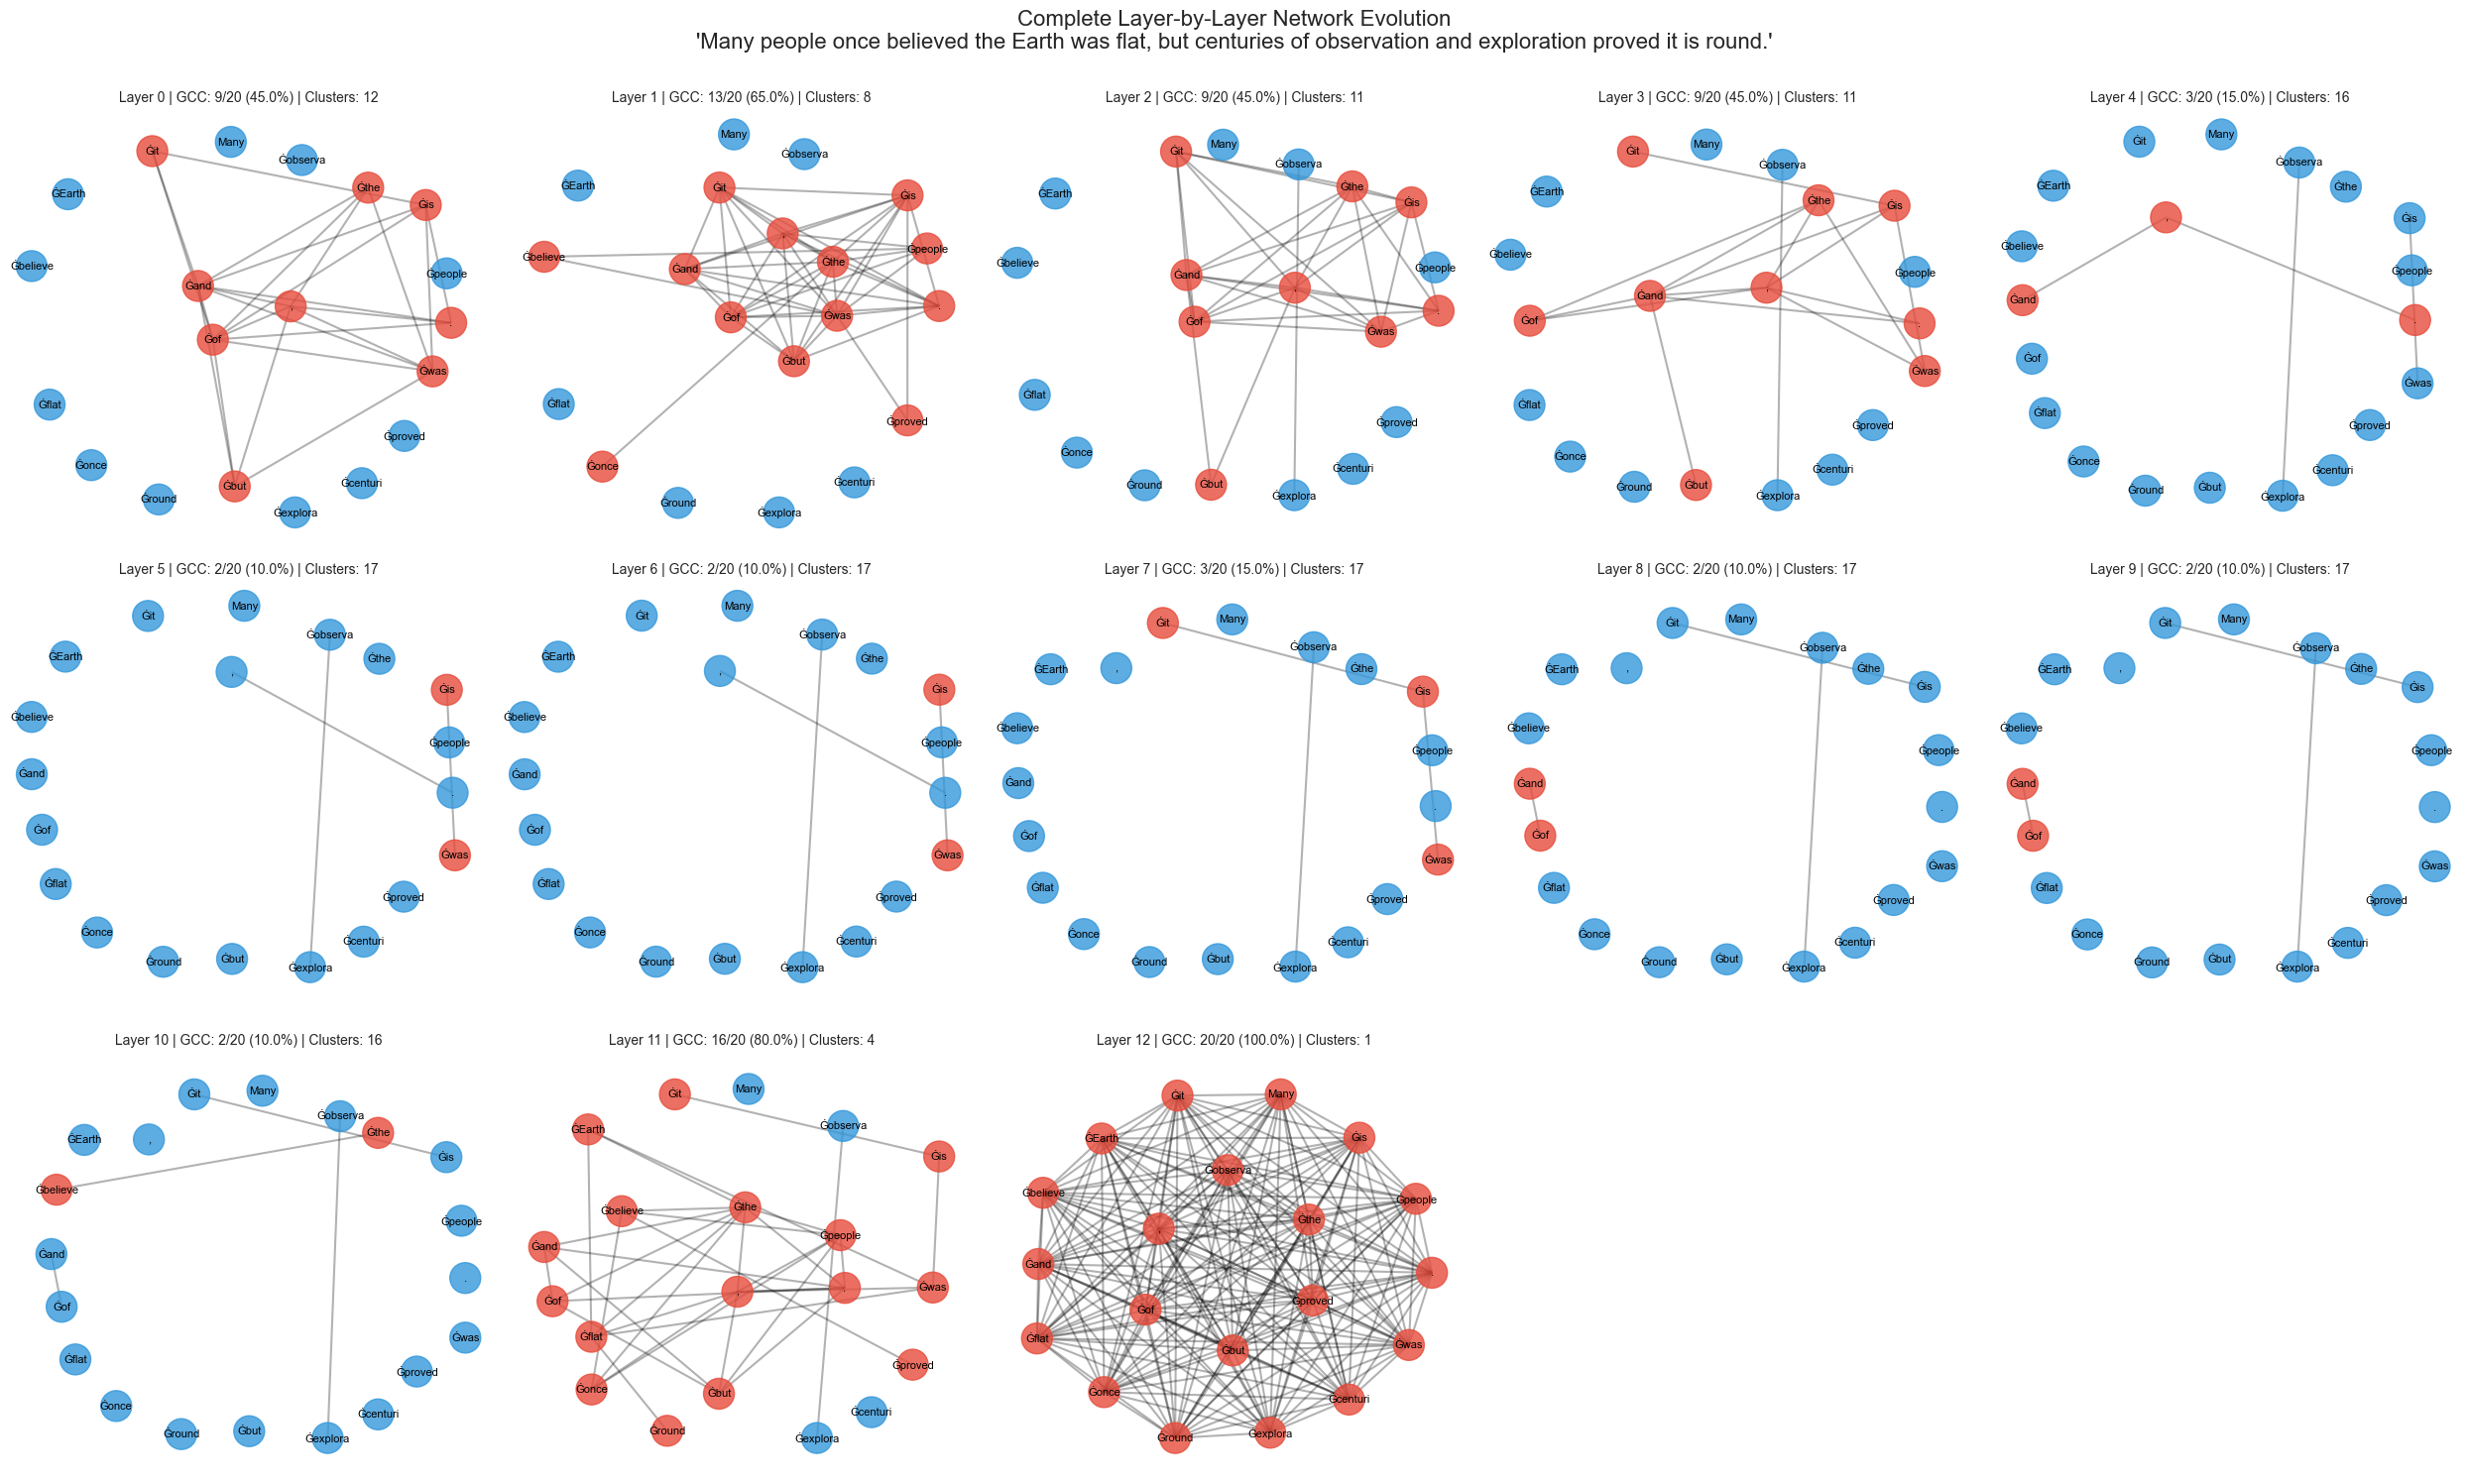

In [51]:
# Show all layers in sequence
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.flatten()

for layer in range(num_layers):
    # Compute similarity matrix
    similarity = compute_similarity_matrix(hidden_states[layer], use_cosine=USE_COSINE)

    # Build graph
    G = build_connectivity_graph(similarity, THRESHOLD, tokens)

    # Visualize
    visualize_network(G, tokens, layer, ax=axes[layer], layout='spring')

# Hide unused subplots
for i in range(num_layers, len(axes)):
    axes[i].axis('off')

plt.suptitle(f"Complete Layer-by-Layer Network Evolution\n'{example_text}'",
            fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## Analyze Multiple Sequences and Show Representative Networks

In [52]:
# Analyze all sequences and collect statistics
print(f"Analyzing {len(CORPUS)} sequences...\n")

all_results = []

for seq_idx, text in enumerate(tqdm(CORPUS)):
    hidden_states, tokens = extract_hidden_states(model, tokenizer, text)

    seq_results = {
        'text': text,
        'tokens': tokens,
        'layers': []
    }

    for layer in range(num_layers):
        similarity = compute_similarity_matrix(hidden_states[layer], use_cosine=USE_COSINE)
        G = build_connectivity_graph(similarity, THRESHOLD, tokens)
        stats = analyze_graph_structure(G)

        seq_results['layers'].append({
            'graph': G,
            'stats': stats
        })

    all_results.append(seq_results)

print("\n✓ Analysis complete")

Analyzing 11 sequences...



100%|██████████| 11/11 [00:00<00:00, 17.23it/s]


✓ Analysis complete


In [53]:
# Compute aggregate statistics
aggregate_stats = {}

for layer in range(num_layers):
    phis = [result['layers'][layer]['stats']['phi'] for result in all_results]
    num_clusters = [result['layers'][layer]['stats']['num_clusters'] for result in all_results]
    chis = [result['layers'][layer]['stats']['chi'] for result in all_results]

    aggregate_stats[layer] = {
        'mean_phi': np.mean(phis),
        'std_phi': np.std(phis),
        'mean_num_clusters': np.mean(num_clusters),
        'std_num_clusters': np.std(num_clusters),
        'mean_chi': np.mean(chis),
        'std_chi': np.std(chis)
    }

In [54]:
# Print summary table
print("\n" + "="*70)
print("SUMMARY STATISTICS ACROSS ALL SEQUENCES")
print("="*70)
print(f"{'Layer':<8} {'Φ (GCC)':<12} {'#Clusters':<15} {'χ (Mean Size)':<15}")
print("-"*70)

for layer in range(num_layers):
    phi = aggregate_stats[layer]['mean_phi']
    phi_std = aggregate_stats[layer]['std_phi']
    nc = aggregate_stats[layer]['mean_num_clusters']
    nc_std = aggregate_stats[layer]['std_num_clusters']
    chi = aggregate_stats[layer]['mean_chi']
    chi_std = aggregate_stats[layer]['std_chi']

    print(f"{layer:<8} {phi:.3f}±{phi_std:.3f}   {nc:.1f}±{nc_std:.1f}         "
          f"{chi:.2f}±{chi_std:.2f}")

print("="*70)


SUMMARY STATISTICS ACROSS ALL SEQUENCES
Layer    Φ (GCC)      #Clusters       χ (Mean Size)  
----------------------------------------------------------------------
0        0.254±0.108   7.6±1.7         0.73±0.45
1        0.535±0.192   4.8±1.8         1.11±0.20
2        0.266±0.102   7.3±1.5         0.83±0.39
3        0.254±0.109   7.3±1.6         0.74±0.45
4        0.171±0.072   8.5±2.6         0.38±0.50
5        0.133±0.032   8.8±2.7         0.18±0.39
6        0.123±0.015   8.9±2.7         0.09±0.29
7        0.137±0.030   8.8±2.7         0.19±0.40
8        0.200±0.077   8.3±2.9         0.64±0.48
9        0.246±0.094   7.9±3.0         0.82±0.39
10       0.341±0.140   6.5±3.3         1.13±0.17
11       0.868±0.025   2.2±0.6         1.03±0.10
12       1.000±0.000   1.0±0.0         0.00±0.00


## Percolation Observables

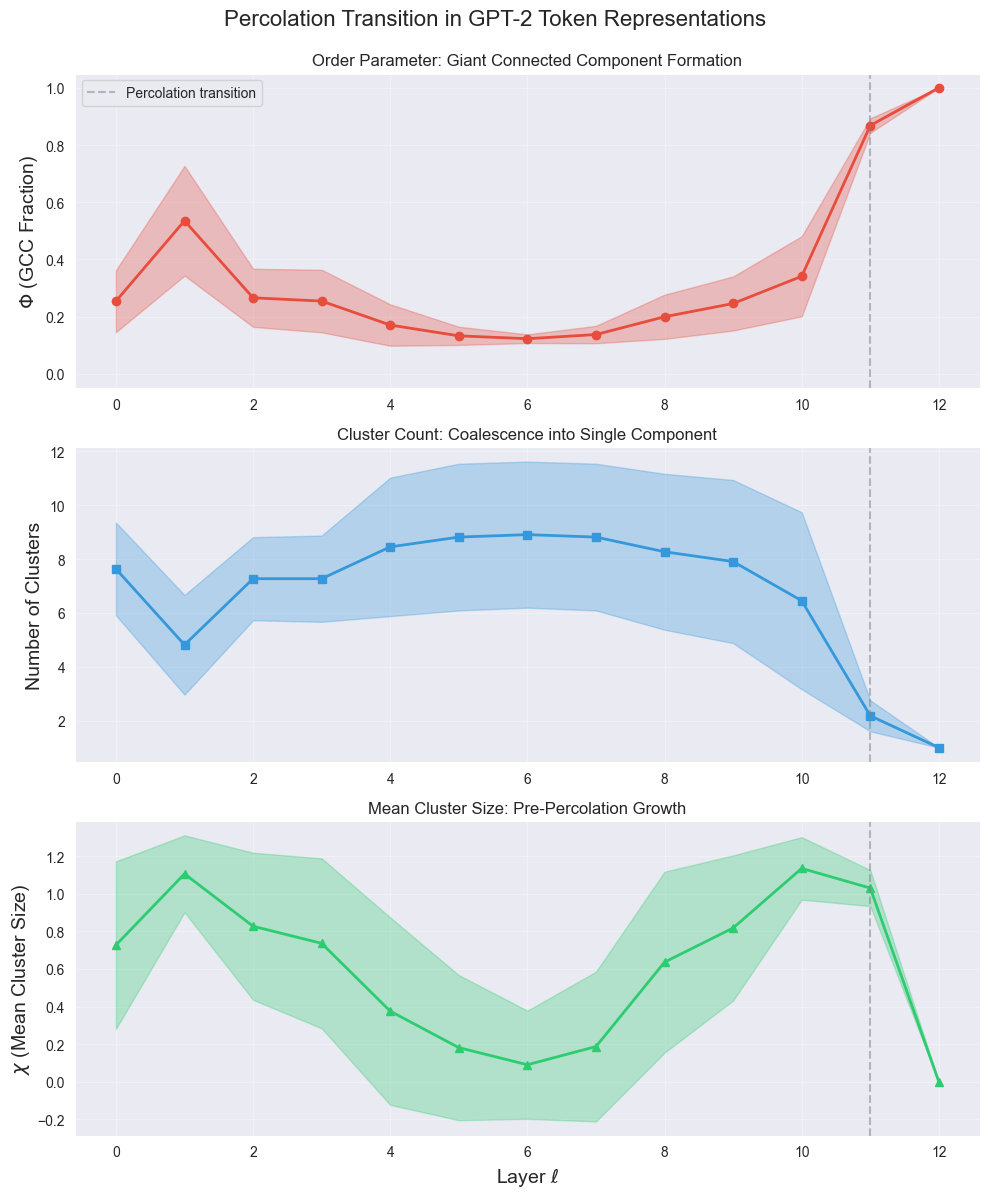

In [55]:
# Plot percolation observables
layers = list(range(num_layers))
mean_phi = [aggregate_stats[l]['mean_phi'] for l in layers]
std_phi = [aggregate_stats[l]['std_phi'] for l in layers]
mean_nc = [aggregate_stats[l]['mean_num_clusters'] for l in layers]
std_nc = [aggregate_stats[l]['std_num_clusters'] for l in layers]
mean_chi = [aggregate_stats[l]['mean_chi'] for l in layers]
std_chi = [aggregate_stats[l]['std_chi'] for l in layers]

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Phi (Order Parameter)
axes[0].plot(layers, mean_phi, 'o-', linewidth=2, markersize=6, color='#e74c3c')
axes[0].fill_between(layers,
                    np.array(mean_phi) - np.array(std_phi),
                    np.array(mean_phi) + np.array(std_phi),
                    alpha=0.3, color='#e74c3c')
axes[0].axvline(x=11, color='gray', linestyle='--', alpha=0.5, label='Percolation transition')
axes[0].set_ylabel(r'$\Phi$ (GCC Fraction)', fontsize=14)
axes[0].set_ylim([-0.05, 1.05])
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_title('Order Parameter: Giant Connected Component Formation', fontsize=12)

# Number of clusters
axes[1].plot(layers, mean_nc, 's-', linewidth=2, markersize=6, color='#3498db')
axes[1].fill_between(layers,
                    np.array(mean_nc) - np.array(std_nc),
                    np.array(mean_nc) + np.array(std_nc),
                    alpha=0.3, color='#3498db')
axes[1].axvline(x=11, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Number of Clusters', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Cluster Count: Coalescence into Single Component', fontsize=12)

# Chi (susceptibility)
axes[2].plot(layers, mean_chi, '^-', linewidth=2, markersize=6, color='#2ecc71')
axes[2].fill_between(layers,
                    np.array(mean_chi) - np.array(std_chi),
                    np.array(mean_chi) + np.array(std_chi),
                    alpha=0.3, color='#2ecc71')
axes[2].axvline(x=11, color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel(r'Layer $\ell$', fontsize=14)
axes[2].set_ylabel(r'$\chi$ (Mean Cluster Size)', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].set_title('Mean Cluster Size: Pre-Percolation Growth', fontsize=12)

plt.suptitle('Percolation Transition in GPT-2 Token Representations',
            fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## Show Representative Networks Before and After Percolation Transition

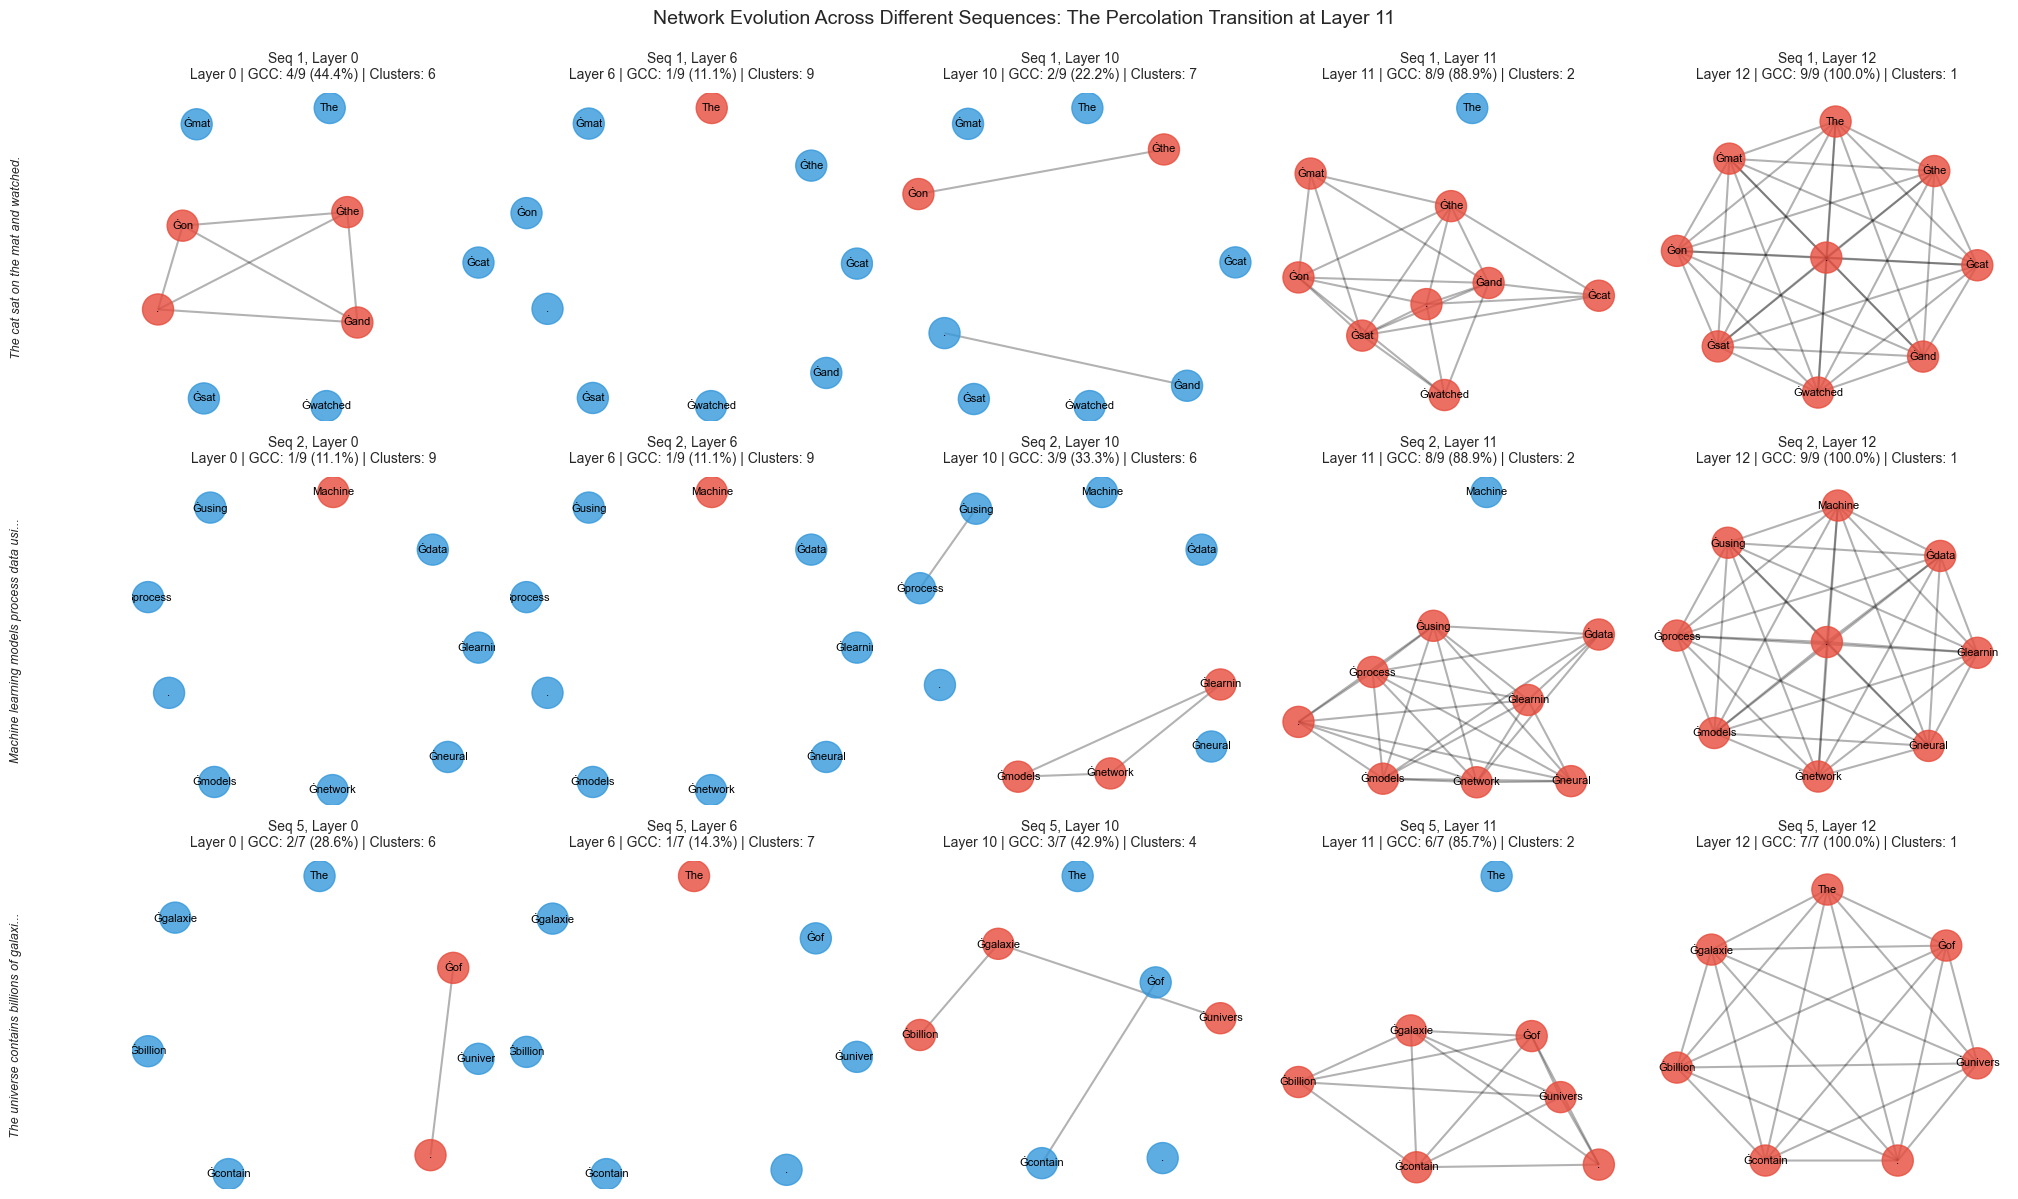

In [56]:
# Pick 3 example sequences and show key layers
example_indices = [0, 1, 4]  # Three different sequences
comparison_layers = [0, 6, 10, 11, 12]  # Early, middle, pre-transition, transition, post

fig, axes = plt.subplots(len(example_indices), len(comparison_layers),
                         figsize=(20, 12))

for row, seq_idx in enumerate(example_indices):
    result = all_results[seq_idx]
    tokens = result['tokens']
    text = result['text'][:40] + '...' if len(result['text']) > 40 else result['text']

    for col, layer in enumerate(comparison_layers):
        G = result['layers'][layer]['graph']
        ax = axes[row, col]

        visualize_network(G, tokens, layer,
                         title=f"Seq {seq_idx+1}, Layer {layer}",
                         ax=ax, layout='spring')

        # Add sequence label on first column
        if col == 0:
            ax.text(-0.3, 0.5, f"{text}",
                   transform=ax.transAxes,
                   rotation=90, va='center', ha='right',
                   fontsize=9, style='italic')

plt.suptitle('Network Evolution Across Different Sequences: The Percolation Transition at Layer 11',
            fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

## Detailed View: Watching Clusters Merge at Layer 11

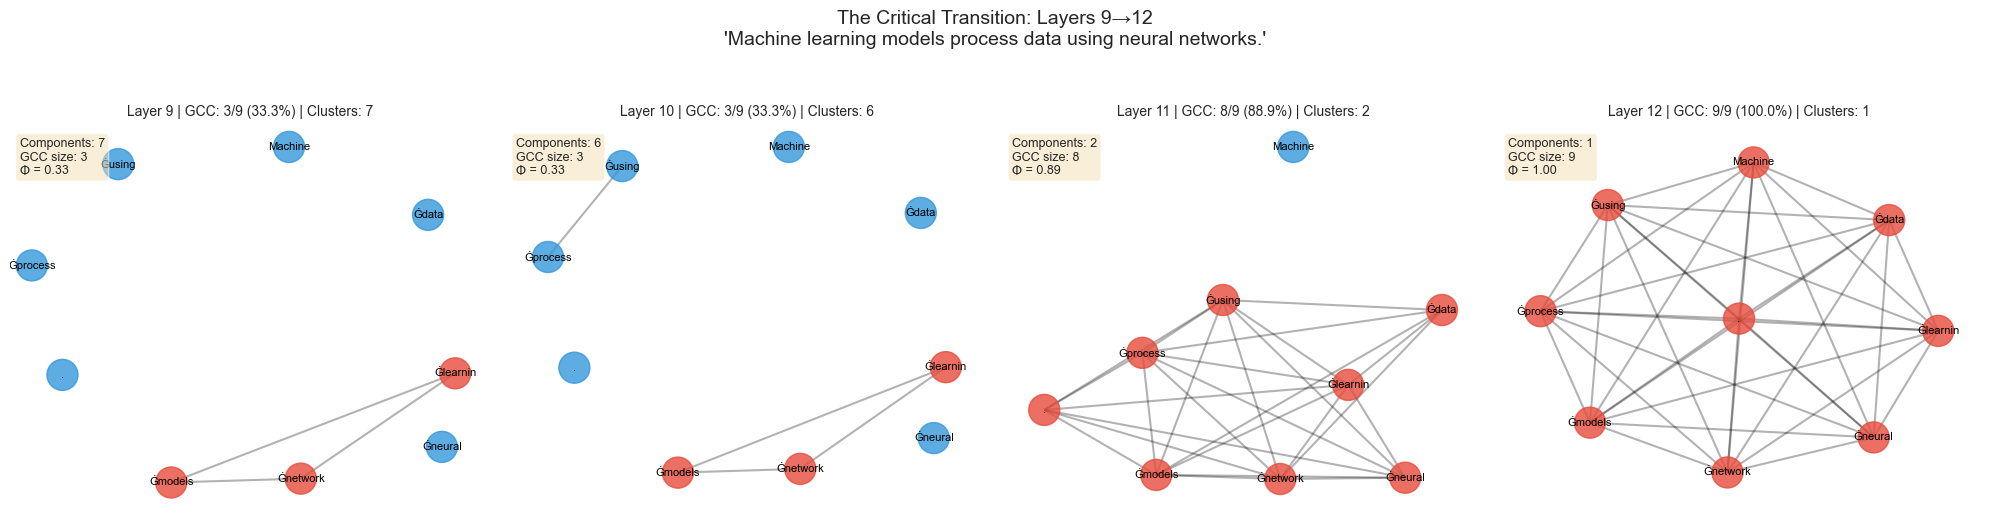

In [57]:
# Focus on the critical transition: layers 9, 10, 11, 12
critical_layers = [9, 10, 11, 12]
example_idx = 1  # Pick one good example

result = all_results[example_idx]
tokens = result['tokens']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, layer in enumerate(critical_layers):
    G = result['layers'][layer]['graph']
    stats = result['layers'][layer]['stats']

    visualize_network(G, tokens, layer, ax=axes[idx], layout='spring')

    # Add detailed statistics
    info_text = f"Components: {stats['num_clusters']}\n"
    info_text += f"GCC size: {stats['largest_component_size']}\n"
    info_text += f"Φ = {stats['phi']:.2f}"

    axes[idx].text(0.02, 0.98, info_text,
                  transform=axes[idx].transAxes,
                  fontsize=9, va='top', ha='left',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f"The Critical Transition: Layers 9→12\n'{result['text']}'",
            fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Summary

This analysis reveals the **percolation transition** in GPT-2's token representations:

1. **Early layers (0-6)**: Tokens remain largely isolated or form small clusters
2. **Middle layers (7-10)**: Gradual cluster growth and some merging
3. **Critical transition (Layer 11)**: Dramatic percolation event where isolated clusters suddenly merge into a giant connected component
4. **Final layer (12)**: Complete connectivity where all tokens are semantically aligned

The network visualizations make this phase transition visible: we can literally watch the moment when the giant connected component emerges, transforming the network topology from fragmented to unified.

In [58]:
import networkx as nx
import os

# 选择一个层的网络，比如第11层的示例网络
example_text = CORPUS[10]
hidden_states, tokens = extract_hidden_states(model, tokenizer, example_text)
similarity = compute_similarity_matrix(hidden_states[11], use_cosine=USE_COSINE)
G = build_connectivity_graph(similarity, THRESHOLD, tokens)

OUTPUT_DIR = "D:\GWU\DATS6450(Cloud Network)\gephi"
# 保存为 GEXF 文件
output_path = os.path.join(OUTPUT_DIR, "corpus10_layer11_network.gexf")
nx.write_gexf(G, output_path)

print(f"Network exported to {output_path}")


Network exported to D:\GWU\DATS6450(Cloud Network)\gephi\corpus10_layer11_network.gexf
